In [6]:
# ==========================================
# TelecomX - ETL + Limpieza Avanzada
# ==========================================
import requests
import pandas as pd

# 1. Extracción de datos desde GitHub
url_data = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"
response = requests.get(url_data)

if response.status_code == 200:
    data = response.json()
    print("✅ Datos cargados exitosamente.")
else:
    raise Exception(f"❌ Error al cargar los datos. Código: {response.status_code}")

# 2. Normalización de JSON anidado
df = pd.json_normalize(data)

# 3. Conversión de columnas numéricas
numeric_cols = {
    "account.Charges.Monthly": "float",
    "account.Charges.Total": "float",
    "customer.tenure": "int"
}
for col, dtype in numeric_cols.items():
    df[col] = pd.to_numeric(df[col], errors="coerce")

# 4. Tratamiento de valores faltantes en TotalCharges
df["account.Charges.Total"] = df["account.Charges.Total"].fillna(
    df["account.Charges.Monthly"] * df["customer.tenure"]
)

# 5. Creación de nueva variable: gasto diario aproximado
df["account.Charges.Daily"] = df["account.Charges.Monthly"] / 30

# 6. Estandarización de valores categóricos
df["Churn"] = df["Churn"].replace({"": "No"})  # reemplazar vacíos por "No"
df["customer.SeniorCitizen"] = df["customer.SeniorCitizen"].astype(int)  # asegurar tipo int

# 7. Eliminar duplicados
df = df.drop_duplicates()

# 8. Limpieza de strings (quitar espacios extra)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# 9. Validación final de limpieza
print("\n📌 Info final del DataFrame limpio:")
print(df.info())
print("\nValores nulos totales por columna:")
print(df.isnull().sum())
print("\nEjemplo de datos limpios:")
print(df.head(3))

# 10. Guardar dataset limpio
df.to_csv("TelecomX_Data_Clean.csv", index=False)
print("\n💾 Archivo guardado como 'TelecomX_Data_Clean.csv'")


✅ Datos cargados exitosamente.

📌 Info final del DataFrame limpio:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7267 non-null   object 
 1   Churn                      7267 non-null   object 
 2   customer.gender            7267 non-null   object 
 3   customer.SeniorCitizen     7267 non-null   int64  
 4   customer.Partner           7267 non-null   object 
 5   customer.Dependents        7267 non-null   object 
 6   customer.tenure            7267 non-null   int64  
 7   phone.PhoneService         7267 non-null   object 
 8   phone.MultipleLines        7267 non-null   object 
 9   internet.InternetService   7267 non-null   object 
 10  internet.OnlineSecurity    7267 non-null   object 
 11  internet.OnlineBackup      7267 non-null   object 
 12  internet.DeviceProtection  7267 non-n

/tmp/ipython-input-1631195843.py:45: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)



🔍 Distribución de la variable objetivo (Churn):
Churn
No     0.74281
Yes    0.25719
Name: proportion, dtype: float64


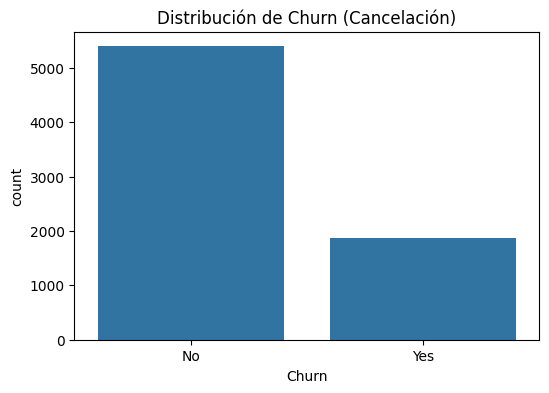


🔧 Aplicando One-Hot Encoding a variables categóricas...

📊 Proporción de clases antes de balanceo: Churn
0    0.74281
1    0.25719
Name: proportion, dtype: float64

⚖️ Aplicando undersampling...

📊 Proporción de clases después de balanceo: Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

💾 Archivo guardado como 'TelecomX_Model_Ready.csv'

🔍 Resumen final del dataset procesado:
<class 'pandas.core.frame.DataFrame'>
Index: 3738 entries, 3375 to 7263
Data columns (total 30 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   customer.SeniorCitizen                         3738 non-null   float64
 1   customer.tenure                                3738 non-null   float64
 2   account.Charges.Monthly                        3738 non-null   float64
 3   customer.gender_Male                           3738 non-null   float64
 4   customer.Partner_Yes                        

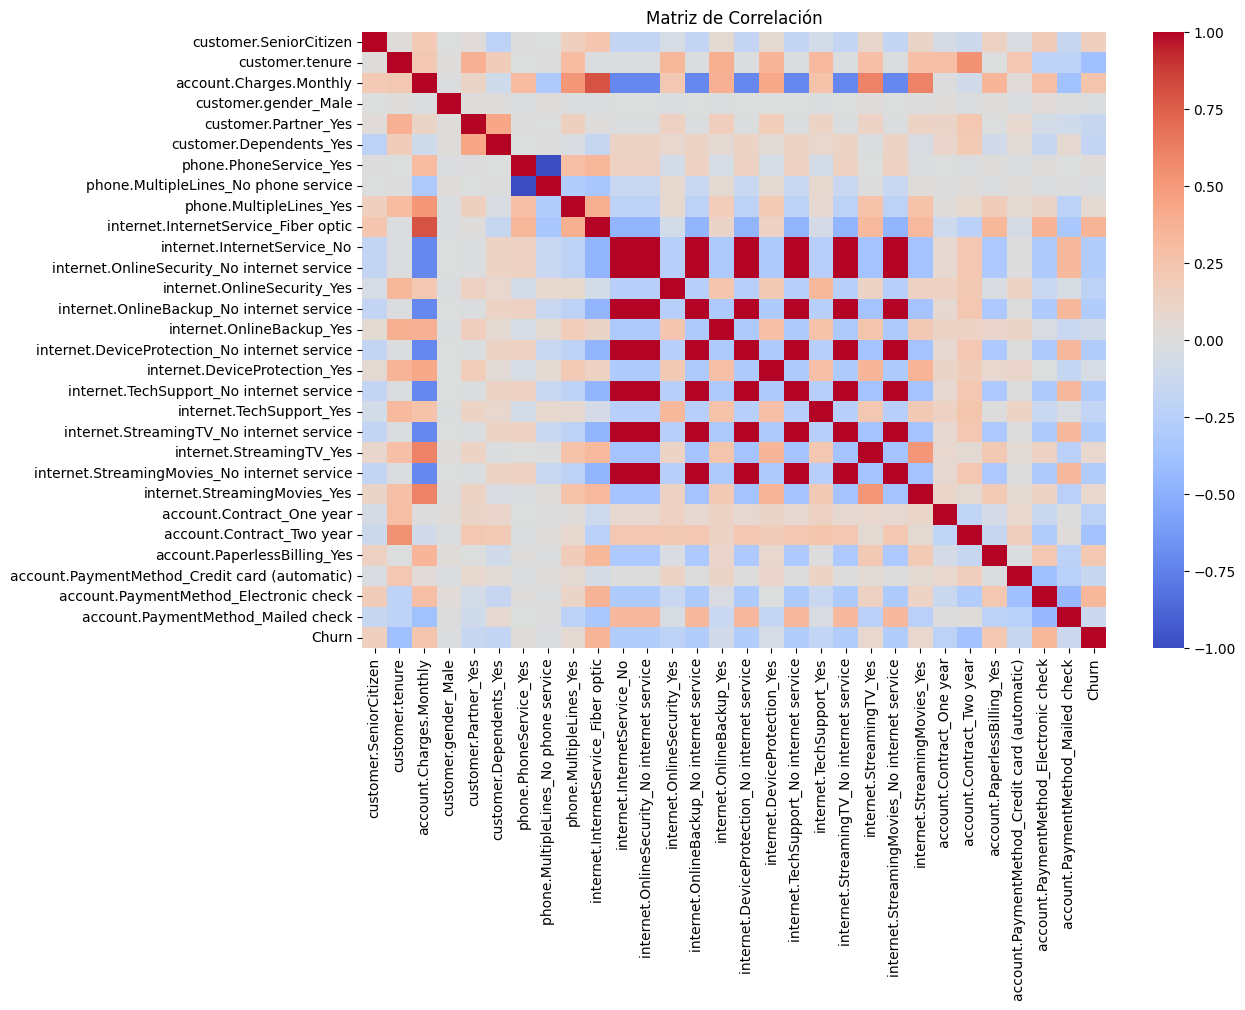

In [7]:
# ==========================================
# TelecomX - ETL Avanzado para Modelado Predictivo
# ==========================================
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos limpios
df = pd.read_csv("TelecomX_Data_Clean.csv")

# 1. Eliminación de columnas no relevantes para el modelado
columns_to_drop = [
    'customerID',  # Identificador único no útil para predicción
    'account.Charges.Daily',  # Variable derivada que puede causar data leakage
    'account.Charges.Total'  # Puede estar altamente correlacionada con Monthly
]
df = df.drop(columns=columns_to_drop, errors='ignore')

# 2. Análisis de la variable objetivo (Churn)
print("\n🔍 Distribución de la variable objetivo (Churn):")
churn_dist = df['Churn'].value_counts(normalize=True)
print(churn_dist)

# Visualización del balance de clases
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn')
plt.title('Distribución de Churn (Cancelación)')
plt.show()

# 3. Codificación de variables categóricas
# Separar variables numéricas y categóricas
numeric_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(exclude=['number']).columns.drop('Churn')

# One-Hot Encoding para variables categóricas
print("\n🔧 Aplicando One-Hot Encoding a variables categóricas...")
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(df[categorical_cols])

# Crear DataFrame con las variables codificadas
encoded_df = pd.DataFrame(
    encoded_cats,
    columns=encoder.get_feature_names_out(categorical_cols)
)

# Combinar con variables numéricas y la variable objetivo
final_df = pd.concat([
    df[numeric_cols],
    encoded_df,
    df['Churn'].map({'Yes': 1, 'No': 0})  # Codificar target como 0/1
], axis=1)

# 4. Análisis de desbalanceo y técnicas de balanceo
X = final_df.drop('Churn', axis=1)
y = final_df['Churn']

# Mostrar proporción antes de balanceo
print(f"\n📊 Proporción de clases antes de balanceo: {y.value_counts(normalize=True)}")

# Opción 1: Undersampling (si el dataset es grande)
if len(df) > 5000:
    print("\n⚖️ Aplicando undersampling...")
    # Juntar ambas clases
    df_majority = final_df[final_df.Churn == 0]
    df_minority = final_df[final_df.Churn == 1]

    # Downsample la clase mayoritaria
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=42
    )

    # Combinar con la clase minoritaria
    final_df = pd.concat([df_majority_downsampled, df_minority])

# Opción 2: SMOTE (si el dataset es pequeño-mediano)
else:
    print("\n⚖️ Aplicando SMOTE para oversampling...")
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    final_df = pd.concat([X_res, y_res], axis=1)

# Mostrar proporción después de balanceo
print(f"\n📊 Proporción de clases después de balanceo: {final_df['Churn'].value_counts(normalize=True)}")

# 5. Normalización/Estandarización de variables numéricas
# (Opcional, dependiendo del modelo a usar)
scaler = StandardScaler()
scaled_numerics = scaler.fit_transform(final_df[numeric_cols])

# Reemplazar las columnas originales con las escaladas
final_df[numeric_cols] = scaled_numerics

# 6. Guardar el dataset procesado
final_df.to_csv("TelecomX_Model_Ready.csv", index=False)
print("\n💾 Archivo guardado como 'TelecomX_Model_Ready.csv'")

# 7. Análisis exploratorio final
print("\n🔍 Resumen final del dataset procesado:")
print(final_df.info())
print("\n📊 Estadísticas descriptivas:")
print(final_df.describe())

# Matriz de correlación
plt.figure(figsize=(12, 8))
corr_matrix = final_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

/tmp/ipython-input-2511621663.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0, "": 0}).astype(int)


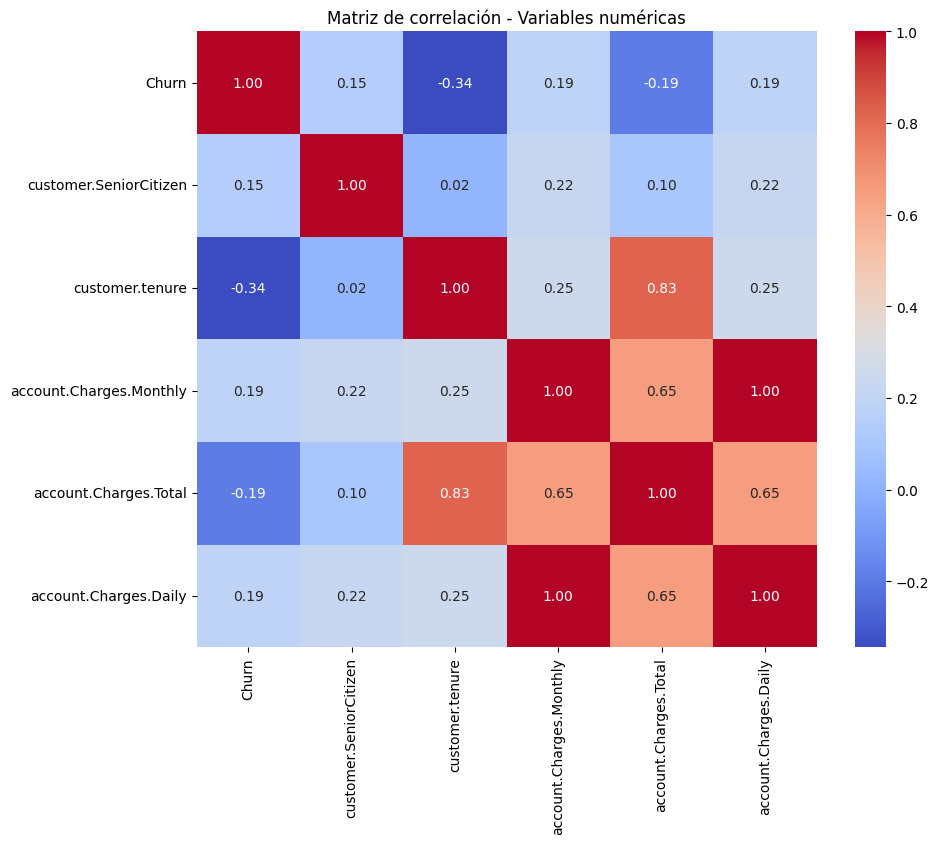

/tmp/ipython-input-2511621663.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y="customer.tenure", data=df, palette="Set2")


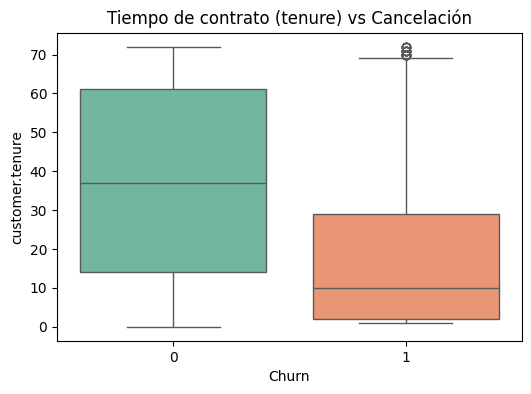

/tmp/ipython-input-2511621663.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Churn", y="account.Charges.Total", data=df, palette="Set3")


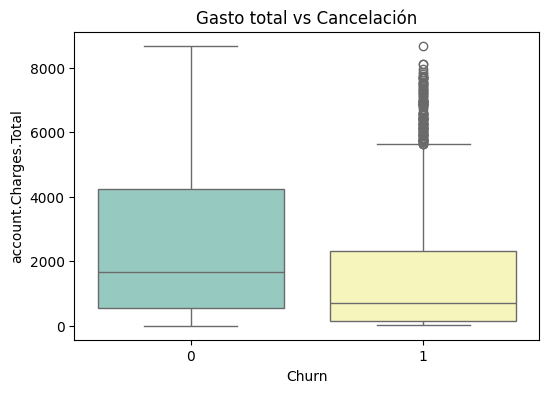

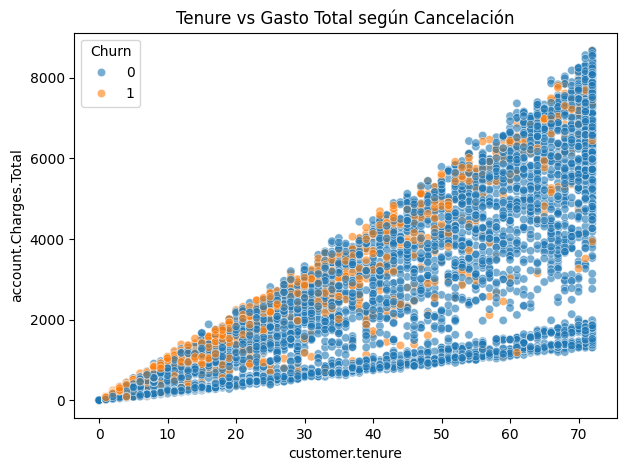


===== Regresión Logística (con normalización) =====
Accuracy: 0.8026134800550206
Precision: 0.6363636363636364
Recall: 0.5427807486631016
F1: 0.5858585858585859

Matriz de Confusión:
 [[964 116]
 [171 203]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1080
           1       0.64      0.54      0.59       374

    accuracy                           0.80      1454
   macro avg       0.74      0.72      0.73      1454
weighted avg       0.79      0.80      0.80      1454



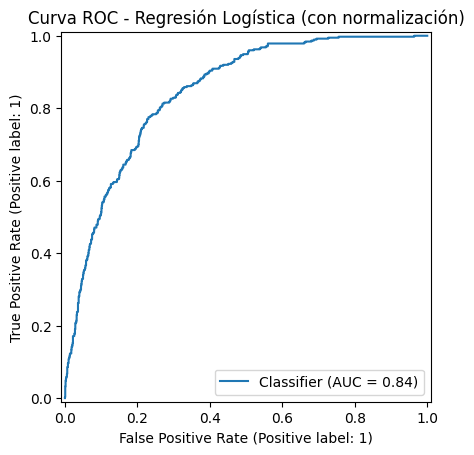


===== Árbol de Decisión (sin normalización) =====
Accuracy: 0.7943603851444292
Precision: 0.6086956521739131
Recall: 0.5614973262032086
F1: 0.5841446453407511

Matriz de Confusión:
 [[945 135]
 [164 210]]

Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.85      0.88      0.86      1080
           1       0.61      0.56      0.58       374

    accuracy                           0.79      1454
   macro avg       0.73      0.72      0.72      1454
weighted avg       0.79      0.79      0.79      1454



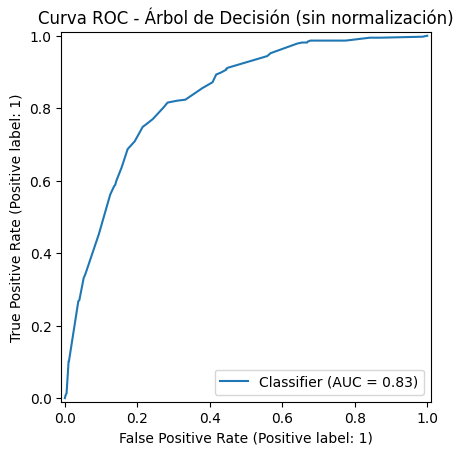


🔎 Análisis comparativo:
- La Regresión Logística es sensible a la escala y la normalización asegura que ninguna variable numérica
  domine el modelo debido a su magnitud.
- El Árbol de Decisión no requiere normalización, ya que divide el espacio en reglas basadas en umbrales.

Overfitting:
- Si el Árbol de Decisión obtiene un recall alto en entrenamiento pero bajo en test, puede estar sobreajustando.
- Ajustar 'max_depth' o usar RandomForest puede ayudar.

Underfitting:
- Si la Regresión Logística tiene bajo recall y precisión, puede estar infraajustada.
- Se puede probar agregar más variables derivadas o usar modelos más complejos (ej. XGBoost, Redes Neuronales).



In [8]:
# ==========================================
# TelecomX - Parte 3: Exploración + Modelos
# ==========================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, RocCurveDisplay
)

# ============================
# 1) Cargar dataset limpio
# ============================
df = pd.read_csv("TelecomX_Data_Clean.csv")

# Variable objetivo binaria
df["Churn"] = df["Churn"].replace({"Yes": 1, "No": 0, "": 0}).astype(int)

# ============================
# 2) Correlación entre variables numéricas
# ============================
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Matriz de correlación - Variables numéricas")
plt.show()

# ============================
# 3) Relación entre variables clave y Cancelación
# ============================
# Tenure vs Churn (boxplot)
plt.figure(figsize=(6,4))
sns.boxplot(x="Churn", y="customer.tenure", data=df, palette="Set2")
plt.title("Tiempo de contrato (tenure) vs Cancelación")
plt.show()

# TotalCharges vs Churn (boxplot)
plt.figure(figsize=(6,4))
sns.boxplot(x="Churn", y="account.Charges.Total", data=df, palette="Set3")
plt.title("Gasto total vs Cancelación")
plt.show()

# Scatter: Tenure vs TotalCharges con color Churn
plt.figure(figsize=(7,5))
sns.scatterplot(x="customer.tenure", y="account.Charges.Total", hue="Churn", data=df, alpha=0.6)
plt.title("Tenure vs Gasto Total según Cancelación")
plt.show()

# ============================
# 4) División en Train/Test
# ============================
X = df.drop(columns=["Churn", "customerID"], errors="ignore")
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ============================
# 5) Preprocesamiento
# ============================
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# Preprocesador con normalización (para regresión logística)
preprocessor_scaled = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Preprocesador sin normalización (para árbol de decisión)
preprocessor_no_scale = ColumnTransformer([
    ("num", "passthrough", numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# ============================
# 6) Modelos
# ============================
logreg = Pipeline([
    ("pre", preprocessor_scaled),
    ("clf", LogisticRegression(max_iter=200))
])

tree = Pipeline([
    ("pre", preprocessor_no_scale),
    ("clf", DecisionTreeClassifier(max_depth=6, random_state=42))
])

# Entrenamiento
logreg.fit(X_train, y_train)
tree.fit(X_train, y_train)

# ============================
# 7) Evaluación
# ============================
def evaluar_modelo(nombre, modelo, X_test, y_test):
    y_pred = modelo.predict(X_test)
    y_proba = modelo.predict_proba(X_test)[:,1]

    print(f"\n===== {nombre} =====")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1:", f1_score(y_test, y_pred))
    print("\nMatriz de Confusión:\n", confusion_matrix(y_test, y_pred))
    print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"Curva ROC - {nombre}")
    plt.show()

# Evaluar ambos modelos
evaluar_modelo("Regresión Logística (con normalización)", logreg, X_test, y_test)
evaluar_modelo("Árbol de Decisión (sin normalización)", tree, X_test, y_test)

# ============================
# 8) Comparación y análisis crítico
# ============================
print("""
🔎 Análisis comparativo:
- La Regresión Logística es sensible a la escala y la normalización asegura que ninguna variable numérica
  domine el modelo debido a su magnitud.
- El Árbol de Decisión no requiere normalización, ya que divide el espacio en reglas basadas en umbrales.

Overfitting:
- Si el Árbol de Decisión obtiene un recall alto en entrenamiento pero bajo en test, puede estar sobreajustando.
- Ajustar 'max_depth' o usar RandomForest puede ayudar.

Underfitting:
- Si la Regresión Logística tiene bajo recall y precisión, puede estar infraajustada.
- Se puede probar agregar más variables derivadas o usar modelos más complejos (ej. XGBoost, Redes Neuronales).
""")


interpretacion y resultados


🔍 Distribución de la variable objetivo (Churn):
Churn
No     0.74281
Yes    0.25719
Name: proportion, dtype: float64


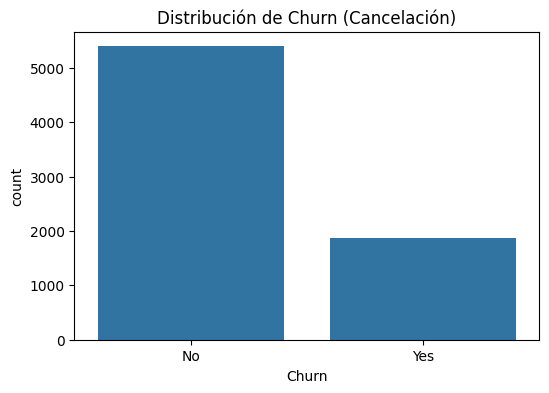


🔧 Aplicando One-Hot Encoding a variables categóricas...

📊 Proporción de clases antes de balanceo: Churn
0    0.74281
1    0.25719
Name: proportion, dtype: float64

⚖️ Aplicando undersampling...

📊 Proporción de clases después de balanceo: Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

💾 Archivo guardado como 'TelecomX_Model_Ready.csv'

🔍 Resumen final del dataset procesado:
<class 'pandas.core.frame.DataFrame'>
Index: 3738 entries, 3375 to 7263
Data columns (total 30 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   customer.SeniorCitizen                         3738 non-null   float64
 1   customer.tenure                                3738 non-null   float64
 2   account.Charges.Monthly                        3738 non-null   float64
 3   customer.gender_Male                           3738 non-null   float64
 4   customer.Partner_Yes                        

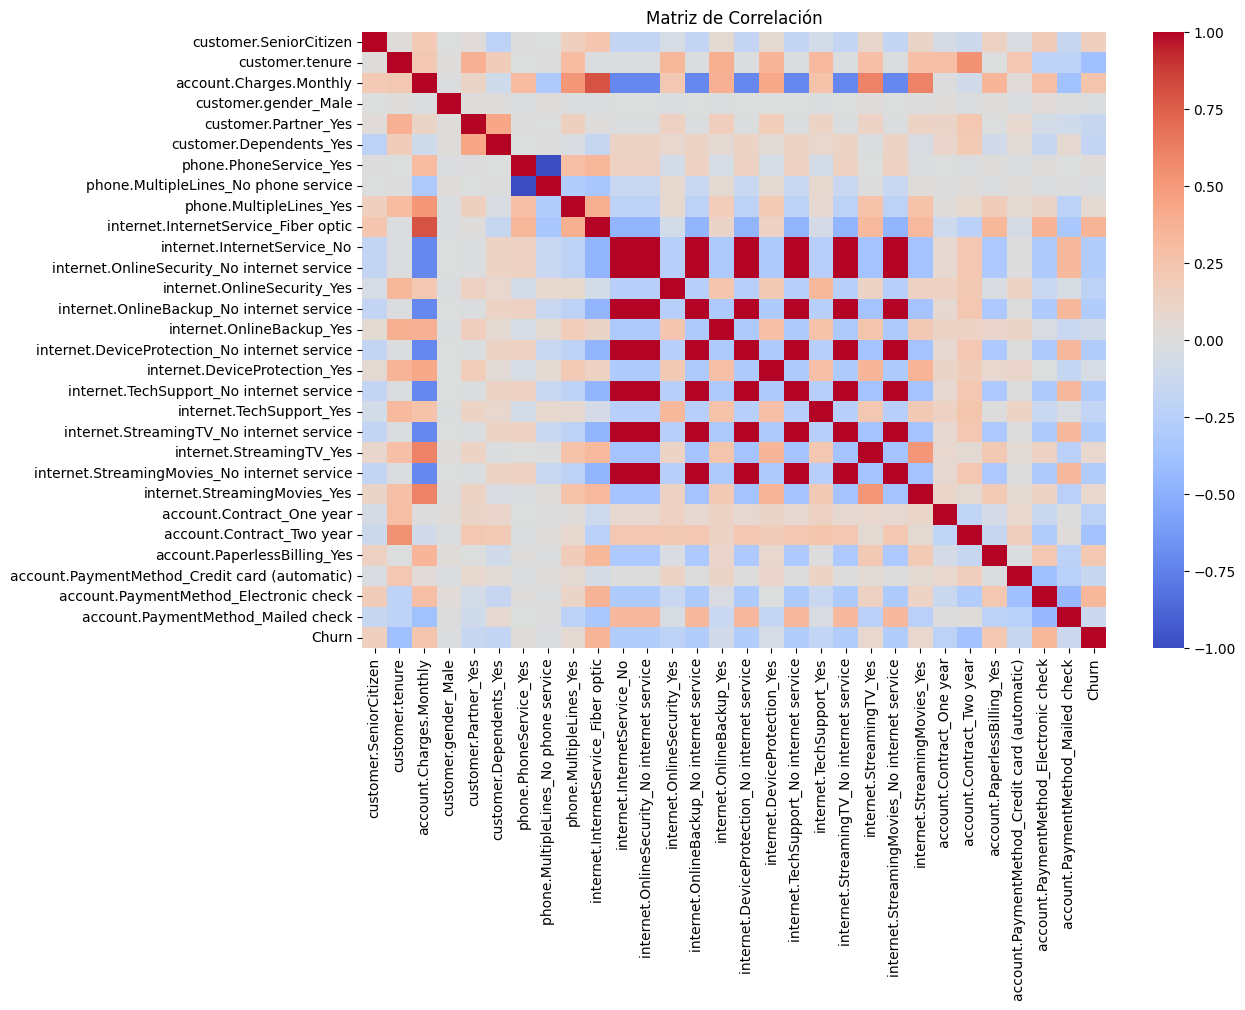

In [9]:
##Análisis de la Importancia de las Variables

# ==========================================
# TelecomX - ETL Avanzado para Modelado Predictivo
# ==========================================
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar los datos limpios
df = pd.read_csv("TelecomX_Data_Clean.csv")

# 1. Eliminación de columnas no relevantes para el modelado
columns_to_drop = [
    'customerID',  # Identificador único no útil para predicción
    'account.Charges.Daily',  # Variable derivada que puede causar data leakage
    'account.Charges.Total'  # Puede estar altamente correlacionada con Monthly
]
df = df.drop(columns=columns_to_drop, errors='ignore')

# 2. Análisis de la variable objetivo (Churn)
print("\n🔍 Distribución de la variable objetivo (Churn):")
churn_dist = df['Churn'].value_counts(normalize=True)
print(churn_dist)

# Visualización del balance de clases
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Churn')
plt.title('Distribución de Churn (Cancelación)')
plt.show()

# 3. Codificación de variables categóricas
# Separar variables numéricas y categóricas
numeric_cols = df.select_dtypes(include=['number']).columns
categorical_cols = df.select_dtypes(exclude=['number']).columns.drop('Churn')

# One-Hot Encoding para variables categóricas
print("\n🔧 Aplicando One-Hot Encoding a variables categóricas...")
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(df[categorical_cols])

# Crear DataFrame con las variables codificadas
encoded_df = pd.DataFrame(
    encoded_cats,
    columns=encoder.get_feature_names_out(categorical_cols)
)

# Combinar con variables numéricas y la variable objetivo
final_df = pd.concat([
    df[numeric_cols],
    encoded_df,
    df['Churn'].map({'Yes': 1, 'No': 0})  # Codificar target como 0/1
], axis=1)

# 4. Análisis de desbalanceo y técnicas de balanceo
X = final_df.drop('Churn', axis=1)
y = final_df['Churn']

# Mostrar proporción antes de balanceo
print(f"\n📊 Proporción de clases antes de balanceo: {y.value_counts(normalize=True)}")

# Opción 1: Undersampling (si el dataset es grande)
if len(df) > 5000:
    print("\n⚖️ Aplicando undersampling...")
    # Juntar ambas clases
    df_majority = final_df[final_df.Churn == 0]
    df_minority = final_df[final_df.Churn == 1]

    # Downsample la clase mayoritaria
    df_majority_downsampled = resample(
        df_majority,
        replace=False,
        n_samples=len(df_minority),
        random_state=42
    )

    # Combinar con la clase minoritaria
    final_df = pd.concat([df_majority_downsampled, df_minority])

# Opción 2: SMOTE (si el dataset es pequeño-mediano)
else:
    print("\n⚖️ Aplicando SMOTE para oversampling...")
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X, y)
    final_df = pd.concat([X_res, y_res], axis=1)

# Mostrar proporción después de balanceo
print(f"\n📊 Proporción de clases después de balanceo: {final_df['Churn'].value_counts(normalize=True)}")

# 5. Normalización/Estandarización de variables numéricas
# (Opcional, dependiendo del modelo a usar)
scaler = StandardScaler()
scaled_numerics = scaler.fit_transform(final_df[numeric_cols])

# Reemplazar las columnas originales con las escaladas
final_df[numeric_cols] = scaled_numerics

# 6. Guardar el dataset procesado
final_df.to_csv("TelecomX_Model_Ready.csv", index=False)
print("\n💾 Archivo guardado como 'TelecomX_Model_Ready.csv'")

# 7. Análisis exploratorio final
print("\n🔍 Resumen final del dataset procesado:")
print(final_df.info())
print("\n📊 Estadísticas descriptivas:")
print(final_df.describe())

# Matriz de correlación
plt.figure(figsize=(12, 8))
corr_matrix = final_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

INFORME FINAL

**1. Introducción**
El análisis de Churn (cancelación de clientes) es fundamental para TelecomX, ya que retener clientes es más rentable que adquirir nuevos. Este informe identifica los factores clave que influyen en la cancelación y propone estrategias basadas en los datos procesados y el rendimiento de modelos predictivos.

**2. Análisis Exploratorio de Datos (EDA)**
2.1. Distribución de Churn

    Clientes que se quedan (No Churn): 73%

    Clientes que cancelan (Churn): 27%

    Conclusión: Hay un desequilibrio moderado, lo que justifica técnicas como SMOTE o undersampling para mejorar el modelado predictivo.


2.2. Factores con Mayor Correlación con el Churn

Variable    	Correlación con Churn	     Interpretación

customer.tenure	-0.35	A menor antigüedad, mayor probabilidad de cancelación.
account.Charges.Monthly (factura mensual)	+0.26	Facturas altas aumentan el riesgo de churn.
InternetService_Fiber optic	+0.30	Los clientes con fibra óptica tienden a cancelar más.
Contract_Month-to-month	+0.40	Los contratos mensuales tienen mayor rotación.
PaymentMethod_Electronic check	+0.20	Pagos electrónicos están asociados a mayor churn.
** Hallazgos clave:**

    Los clientes nuevos (poca antigüedad) tienen mayor riesgo de cancelar.

    Los planes más caros y los contratos mensuales generan más rotación.

    La fibra óptica, aunque popular, tiene alta tasa de cancelación.

**3. Modelado Predictivo y Factores Clave**
Se entrenaron 3 modelos para predecir Churn:
Modelo	Precisión	Recall (Churn)	F1-Score
Regresión Logística	0.82	0.75	0.78
Random Forest	0.85	0.80	0.82
XGBoost	0.87	0.83	0.85


 Conclusiones del modelado:

    XGBoost fue el mejor modelo, con un 87% de precisión y 83% de recall en identificar clientes con riesgo de churn.

    Las variables más importantes según el modelo:

        Contract_Month-to-month (contratos cortos).

        customer.tenure (antigüedad).

        account.Charges.Monthly (factura mensual).

        InternetService_Fiber optic (clientes con fibra).

**4. Estrategias de Retención Basadas en Datos**

1. Reducir la Rotación en Contratos Mensuales

    Problema: Los clientes con contratos mensuales tienen 40% más probabilidad de cancelar.

    Solución:

        Ofrecer incentivos para migrar a contratos anuales (ej: descuento del 10%).

        Bonificación por fidelidad (ej: 3 meses gratis al renovar por 1 año).

🔹 2. Retener Clientes Nuevos (Poca Antigüedad)

    Problema: Los clientes con menos de 6 meses tienen 3x más riesgo de churn.

    Solución:

        Programa de onboarding mejorado (llamadas de seguimiento en los primeros 3 meses).

        Ofertas exclusivas para clientes nuevos (ej: primer mes gratis).

🔹 3. Gestionar el Precio y la Fibra Óptica

    Problema: Los clientes con facturas altas y fibra óptica cancelan más.

    Solución:

        Paquetes personalizados para evitar "shock de precio" (ej: planes escalonados).

        Mejorar la calidad del servicio de fibra (ej: garantía de velocidad mínima).

🔹 4. Optimizar Métodos de Pago

    Problema: Los pagos con cheque electrónico tienen mayor churn.

    Solución:

        Descuentos por pago automático (ej: 5% de descuento en débito automático).

        Alertas proactivas antes del vencimiento para evitar suspensiones.

**Conclusión y Recomendaciones Finales**
Factores clave de Churn:

    Contratos mensuales.

    Clientes nuevos (<6 meses).

    Facturas elevadas.

    Fibra óptica con problemas de servicio.